In [1]:
import atlas

import os
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Solar model with ATLAS

This is the simplest use case for `BasicATLAS`, where we calculate the structure and emergent spectrum for the atmosphere of a Sun-like star ($T_\mathrm{eff}=5770\ \mathrm{K}$, $\log(g)=4.44$, standard solar chemistry).

We will use `~/ATLAS_sun_model` as our work directory. First, make sure the folder does not already exist; and if it does, **remove it**.

In [2]:
rm -rf ~/ATLAS_sun_model

## Structure

The structure (i.e. variation of physical parameters such as *pressure* and *temperature* with *depth*) must be calculated first using `ATLAS-9` which is dispatched with `atlas.atlas()`. In the absence of arguments, the routine will default to solar parameters listed above as well as a set of solar opacity distribution functions provided in `data/solar_ODF`.

In [3]:
run_dir = os.path.expanduser('~/ATLAS_sun_model')
atlas.atlas(run_dir)

Chose closest model from the restart grid with (Teff,log(g),[M/H],[a/M],[C/M])=(5800.0,4.5,0.0,0.0,0.0)
Launcher created
ATLAS-9 halted
Total iterations: 30 | Best iteration: 30
For the best iteration: max[|err|] = 0.0917 | max[|de|] = 3.47 | convergence class: GOLD
ATLAS requested/received validation for /home/roman/ATLAS_sun_model successful
Finished running ATLAS-9 in 0:00:48.281369 s


Let's break down the printed output.

* First, `BasicATLAS` told us that it chose a particular pre-existing model from the *restart grid* and used it as the initial guess for the temperature profile of the star. Since the equations of stellar structure are highly non-linear, a good initial guess is necessary. In most cases, the initial guess is taken from another model atmosphere (the so-called *restart model*) that has similar parameters to the ones we want. `BasicATLAS` is shipped with an extensive grid of restart models, from which it can choose the nearest one. Alternatively, the user can provide one of their own models as restart, or choose a gray atmosphere restart, using the `restart` argument of `atlas.atlas()`.
* The structure of the star is calculated iteratively. At each iteration, *temperature corrections* are applied to the temperature profile of the star in order to minimize the flux error and the flux derivative error. By default, `BasicATLAS` will carry out up to 450 iterations and choose the best iteration as the final result (in most cases, the last iteration is the best iteration; however, significant non-linearities may cause temperature corrections to fail, resulting in diverging models). If the calculation fails or if good model convergence is attained sooner than in 450 iterations, `BasicATLAS` may stop after a smaller number of iterations, as is the case here. The printed output contains the total number of iterations carried out and the number of the best iteration which was adopted as the final result.
* `BasicATLAS` also prints the maximum flux error (`max[|err|]`), the maximum flux derivative error (`max[|de|]`) and a qualitative description of final convergence (`GOLD`, `SILVER`, `BRONZE` or `UNCONVERGED`)

We can now plot the calculated temperature/pressure profile:

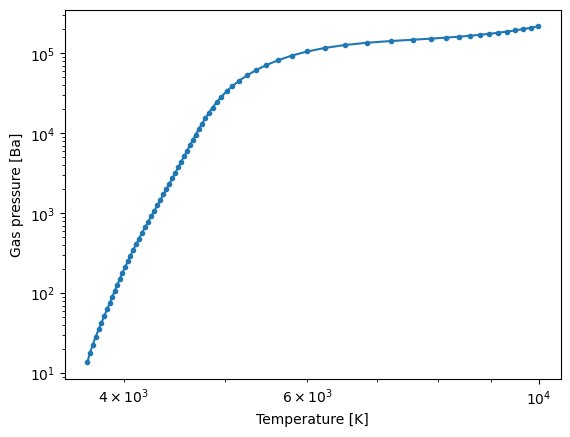

In [4]:
# Load the structure data from the model
structure, units = atlas.read_structure(run_dir)

# Plot it
plt.plot(structure['temperature'], structure['gas_pressure'], '.-')
plt.xlabel('Temperature [{}]'.format(units['temperature']))
plt.ylabel('Gas pressure [{}]'.format(units['gas_pressure']))
plt.yscale('log')
plt.xscale('log')

Individual points in the plot above represent the layers in the stratification of the model. Typically, `ATLAS-9` uses 72 individual layers. More information on other physical properties available in the structure output as well as units can be found in the dedicated tutorial notebook, `output.ipynb`.

## Spectral synthesis

The emergent spectrum of the Sun can now be calculated with the `SYNTHE` code. `SYNTHE` is dispatched in the cell below between the wavelengths of $100$ nm and $3000$ nm. By default, the calculation is carried out at the resolution of $\lambda/\Delta\lambda=6\times10^{5}$. Due to the specific approximations used in `SYNTHE`, much lower resolutions may suffer from numerical artifacts. For this reason, it is recommended to use a higher-than-necessary resolution in the calculation and bin the output after the fact.

<div class="alert alert-block alert-warning">
    <b>Note on performance:</b> <code>SYNTHE</code> relies heavily on disk input while running. To improve performance, it is strongly recommended to place the output directory on the fastest storage device available. Using slower storage such as external hard drives may increase the computation time by a considerable factor.
</div>

In [5]:
atlas.synthe(run_dir, 100, 3000)

Adapted the ATLAS-9 model to SYNTHE in output_synthe.out
Launcher created for wavelength range (100, 2850), batch 1. Expected number of points: 2009944 (buffer 2010001)


199.0it [10:58,  3.31s/it]                                                      


SYNTHE halted
ATLAS requested/received validation for /home/roman/ATLAS_sun_model successful
SYNTHE requested/received validation for /home/roman/ATLAS_sun_model successful
Launcher created for wavelength range (2850, 3000), batch 2. Expected number of points: 30776 (buffer 2010001)


199.0it [00:44,  4.52it/s]                                                      

SYNTHE halted
ATLAS requested/received validation for /home/roman/ATLAS_sun_model successful
SYNTHE requested/received validation for /home/roman/ATLAS_sun_model successful
Finished running SYNTHE in 0:11:42.173506 s


For a particularly wide range of wavelengths such as the one used above, the total number of wavelength points may exceed the buffer size allocated by `SYNTHE`, in which case the program is dispatched multiple times in batches, each containing fewer wavelength points than the buffer size. The buffer size as well as the resolution of the calculation can be set with the optional arguments `res` and `buffsize`.

Other important optional arguments include:

* `vturb` sets the turbulent velocity of the atmosphere in $\mathrm{km}\ \mathrm{s}^{-1}$ (defaults to $1.5$)
* `abun_adjust` allows the use of different chemical abundances in spectral synthesis from the ones used in the structure calculation. This is particularly useful for elements that have very few absorption lines and do not affect the structure significantly. This way, the abundances of those elements can be varied (e.g. to measure the chemical composition from an observed spectrum) without recalculating the structure every time
* `C12C13` sets the adopted carbon-12 to carbon-13 ratio (defaults to $\sim90$)
* `linelist` sets the atomic line list used in the calculation. By default, the recommended `BasicATLAS` line list is used, which was compiled from multiple sources (see `data/linelists/README.txt`)
* `air_wl` allows the calculation to be carried out in air wavelengths (vacuum is default)

Now plot the synthetic spectrum:

Text(0, 0.5, 'Intensity [erg s$^{-1}$ cm$^{-2}$ A$^{-1}$ strad$^{-1}$]')

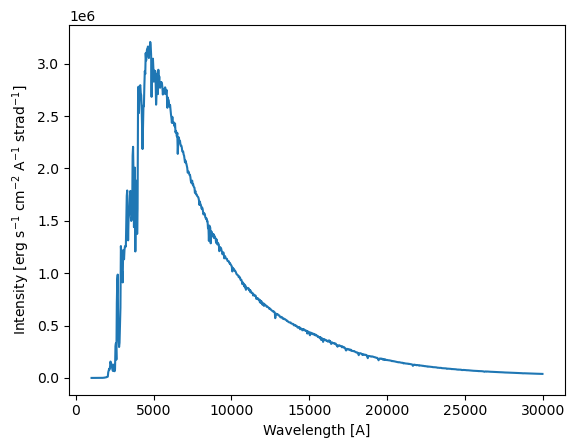

In [6]:
# By default, read_spectrum() returns the spectrum in full resolution, which is difficult to 
# visualize. The optional argument "num_bins" automatically folds the spectrum into the specified
# number of uniform wavelength bins, making it far more presentable
spectrum = atlas.read_spectrum(run_dir, num_bins = 1000)

# Plot the spectrum with MatPlotLib
plt.plot(spectrum['wl'], spectrum['flux'])
plt.xlabel('Wavelength [A]')
plt.ylabel('Intensity [erg s$^{-1}$ cm$^{-2}$ A$^{-1}$ strad$^{-1}$]')

Instead of binning the spectrum, one may choose to examine a particular feature up close at full resolution. For example, the cell below plots the sodium D doublet at $589$ nm:

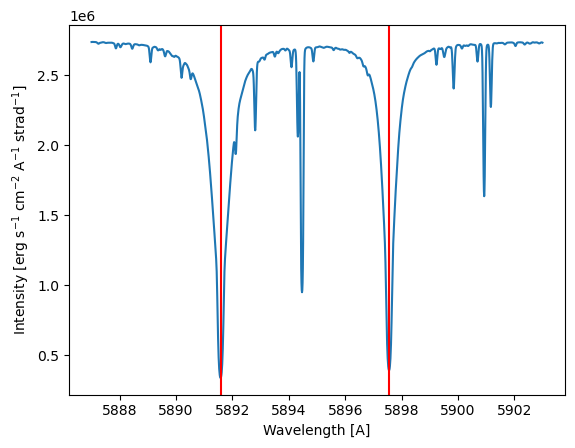

In [7]:
# No binning this time
spectrum = atlas.read_spectrum(run_dir)

# Range of wavelengths to plot
mask = (spectrum['wl'] > 5887) & (spectrum['wl'] < 5903)

# Plot the spectrum with MatPlotLib
plt.plot(spectrum['wl'][mask], spectrum['flux'][mask])
plt.xlabel('Wavelength [A]')
plt.ylabel('Intensity [erg s$^{-1}$ cm$^{-2}$ A$^{-1}$ strad$^{-1}$]')

# Mark line centers (from Juncar+1981)
plt.axvline(5891.58, color = 'r')
plt.axvline(5897.56, color = 'r')